# Проект "One click"

## Описание проекта <a id='0'></a>

**Заказчик**: интернет-магазин розничной торговли «В один клик».  

**Бизнес проблема**: отчёт магазина за прошлый период показал, что активность покупателей начала снижаться.  

**Цель проекта**: разработать модель МО, которая предскажет вероятность снижения покупательской активности в интернет-магазине «В один клик», а также выделить и проанализировать клиентские сегменты в целях стимулирования покупательской активности магазина

**План работ**:  

1. [Описание проекта](#0)
2. [Описание и загрузка данных](#1)
3. [Изучение и предобработка данных](#2)
4. [Исследовательский анализ данных](#3)
5. [Объединение таблиц](#4)
6. [Корреляционный анализ данных](#5)
7. [Построение модели c помощью пайплайнов](#6)
8. [Анализ важности признаков](#7)
9. [Сегментация клиентов](#8)
10. [Заключение](#9)

## Описание и загрузка данных <a id="1"></a>

Данные для работы находятся в четырёх таблицах:
- `market_file.csv`;
- `market_money.csv`;
- `market_time.csv`;
- `money.csv`.

### market_file.csv
*Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.*

- `id` — номер покупателя в корпоративной базе данных.  
- `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

### market_money.csv
*Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.*

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- `Выручка` — сумма выручки за период.

### market_time.csv
*Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.*

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.

### money.csv
*Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.*

- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.

Импортируем библеотки, необходимые для анализа:

In [1]:
# importing libraries
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from scipy import stats as st
from scipy.stats import spearmanr

from phik import phik
from phik.report import plot_correlation_matrix

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Install additional packages
!pip install shap -q
!pip install phik -q

Загрузим датасеты и присвоим им соответствующие переменные:

In [2]:
# money: разделитель - точка с запятой, для цифр - запятая
# market time: разделитель - запятая, для цифр - нет
# market money: разделить - запятая, для цифр - точка
# market file: разделитель - запятая, для цифр - точка

def csv_reader(pth):
    if os.path.exists(pth):
        if pth == 'money.csv':
            return pd.read_csv(pth, sep=';', decimal=',')
        return pd.read_csv(pth, sep=',', decimal='.')
    elif os.path.exists(os.path.join('/datasets', pth)):
        if os.path.join('/datasets', pth) == '/datasets/money.csv':
            return pd.read_csv(os.path.join('/datasets', pth), sep=';', decimal=',')
        return pd.read_csv(os.path.join('/datasets', pth), sep=',', decimal='.')
    
market_file = csv_reader('market_file.csv')
market_money = csv_reader('market_money.csv')
market_time = csv_reader('market_time.csv')
money = csv_reader('money.csv')

## Изучение и предобработка данных <a id="2"></a>

Взглянем на датасеты:

In [3]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [4]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [5]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [6]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Заметим, что названия столбцов написано некорректно. Приведем их к змеиному регистру:

In [7]:
market_file_columns = {
    'Покупательская активность' : 'buying_activity',
    'Тип сервиса' : 'service_type',
    'Разрешить сообщать' : 'advertisement_permission',
    'Маркет_актив_6_мес' : 'marketing_activity_6_months',
    'Маркет_актив_тек_мес': 'marketing_activity_current_month',
    'Длительность' : 'registration_duration',
    'Акционные_покупки' : 'discount_purchases_6_months',
    'Популярная_категория' : 'popular_category_6_month',
    'Средний_просмотр_категорий_за_визит' : 'average_categories_number_last_month',
    'Неоплаченные_продукты_штук_квартал' : 'unpaid_cart_items_3_months',
    'Ошибка_сервиса' : 'errors_number',
    'Страниц_за_визит' : 'average_pages_number_3_months'
    
}

market_money_columns = {
    'Период' : 'period',
    'Выручка' : 'revenue'
}

market_time_columns = {
    'Период' : 'period',
    'минут' : 'time_spent_minutes'
}

money_columns = {
    'Прибыль' : 'profit'
}
    
market_file = market_file.rename(columns=market_file_columns)
market_money = market_money.rename(columns=market_money_columns)
market_time = market_time.rename(columns=market_time_columns)
money = money.rename(columns=money_columns)

Посмотрим на форму, дубликаты и пропуски в столбцах, используя функцию:

In [8]:
def main_info_about_df(df):
    display(df.head())
    print()
    print('-----------------------------------------')
    print()
    display(df.info())
    print()
    print('-----------------------------------------')
    print()
    display('Размер таблицы: ', df.shape)
    print()
    print('-----------------------------------------')
    print()
    display('Количество явных дубликатов: ', df.duplicated().sum())
    print()
    print('-----------------------------------------')
    print()
    display('Количество пропусков в каждом столбце таблицы:')
    display(df.isna().sum())
    
for dataset in [market_file, market_money, market_time, money]:
    main_info_about_df(dataset)

,id,buying_activity,service_type,advertisement_permission,marketing_activity_6_months,marketing_activity_current_month,registration_duration,discount_purchases_6_months,popular_category_6_month,average_categories_number_last_month,unpaid_cart_items_3_months,errors_number,average_pages_number_3_months
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2



-----------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    1300 non-null   int64  
 1   buying_activity                       1300 non-null   object 
 2   service_type                          1300 non-null   object 
 3   advertisement_permission              1300 non-null   object 
 4   marketing_activity_6_months           1300 non-null   float64
 5   marketing_activity_current_month      1300 non-null   int64  
 6   registration_duration                 1300 non-null   int64  
 7   discount_purchases_6_months           1300 non-null   float64
 8   popular_category_6_month              1300 non-null   object 
 9   average_categories_number_last_month  1300 non-null   int64  
 10  unpaid_cart_items_3_months            13

None


-----------------------------------------



'Размер таблицы: '

(1300, 13)


-----------------------------------------



'Количество явных дубликатов: '

0


-----------------------------------------



'Количество пропусков в каждом столбце таблицы:'

id                                      0
buying_activity                         0
service_type                            0
advertisement_permission                0
marketing_activity_6_months             0
marketing_activity_current_month        0
registration_duration                   0
discount_purchases_6_months             0
popular_category_6_month                0
average_categories_number_last_month    0
unpaid_cart_items_3_months              0
errors_number                           0
average_pages_number_3_months           0
dtype: int64

,id,period,revenue
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6



-----------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   period   3900 non-null   object 
 2   revenue  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None


-----------------------------------------



'Размер таблицы: '

(3900, 3)


-----------------------------------------



'Количество явных дубликатов: '

0


-----------------------------------------



'Количество пропусков в каждом столбце таблицы:'

id         0
period     0
revenue    0
dtype: int64

,id,period,time_spent_minutes
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13



-----------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  2600 non-null   int64 
 1   period              2600 non-null   object
 2   time_spent_minutes  2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None


-----------------------------------------



'Размер таблицы: '

(2600, 3)


-----------------------------------------



'Количество явных дубликатов: '

0


-----------------------------------------



'Количество пропусков в каждом столбце таблицы:'

id                    0
period                0
time_spent_minutes    0
dtype: int64

,id,profit
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21



-----------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1300 non-null   int64  
 1   profit  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None


-----------------------------------------



'Размер таблицы: '

(1300, 2)


-----------------------------------------



'Количество явных дубликатов: '

0


-----------------------------------------



'Количество пропусков в каждом столбце таблицы:'

id        0
profit    0
dtype: int64

In [9]:
for dataset in [market_file, market_money, market_time]:
    display(pd.DataFrame(dataset.head()))

,id,buying_activity,service_type,advertisement_permission,marketing_activity_6_months,marketing_activity_current_month,registration_duration,discount_purchases_6_months,popular_category_6_month,average_categories_number_last_month,unpaid_cart_items_3_months,errors_number,average_pages_number_3_months
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


,id,period,revenue
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


,id,period,time_spent_minutes
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Заметим, что в столбцах `discount_purchases_6_months` и `marketing_activity_6_months` неправильный тип данных - "object" (а должен быть float64). Скорректируем, изменив тип данных у значний этих столбцов:

In [10]:
market_file['marketing_activity_6_months'] = pd.to_numeric(market_file['marketing_activity_6_months'])
market_file['discount_purchases_6_months'] = pd.to_numeric(market_file['discount_purchases_6_months'])

Посмотрим на количество и уникальность ID в датасетах:

In [11]:
print(market_file.id.value_counts().unique())
print(market_money.id.value_counts().unique())
print(market_time.id.value_counts().unique())

[1]
[3]
[2]


В датасете `market_file` представлено по одной записи на каждый ID, в `market_money` по 3 записи, в `market_time` по две записи. Это совпадает за отношением количества строк в таблицах и значениями столбцов в них.

Посмотрим на уникальные значения других категориальных признаков таблиц:

In [12]:
dts = [market_file, market_money, market_time, money]

#market_file
dts0_cat_cat = ['buying_activity', 'service_type', 'advertisement_permission', 'popular_category_6_month']

for cat in dts0_cat_cat:
    print(dts[0][cat].unique())
    print()
print('---------------') 
print()

#market_money
print(dts[1]['period'].unique())
print()
print('---------------') 
print()

#market_time
print(dts[2]['period'].unique())

['Снизилась' 'Прежний уровень']

['премиум' 'стандартт' 'стандарт']

['да' 'нет']

['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']

---------------

['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']

---------------

['текущий_месяц' 'предыдцщий_месяц']


Заметим, что в таблице `market_file` в столбце `service_type` присутсвует неправильное написанный тип сервиса - "стандартт". Изменим подобные значения на "стандарт":

In [13]:
def service_type_correcter(service_type):
    if service_type == 'стандартт':
        service_type = 'стандарт'
    return service_type

market_file['service_type'] = market_file['service_type'].apply(service_type_correcter)

Аналогичным образом поменяем опечатку в слове *"предыдцщий_месяц"* в столбце `period` таблицы `market_time`:

In [14]:
def period_correcter(period):
    if period == 'предыдцщий_месяц':
        period = 'предыдущий_месяц'
    return period

market_time['period'] = market_time['period'].apply(period_correcter)

<div class="alert"; style="border-left: 7px solid pink">

**Мини-вывод**
- Названия столбцов были приведены к змеиному регистру;
- Исправлены ошибки в значениях категориальных признаков;
- Пропусков нет;
- Дубликатов нет;
- Соотношение количества уникальных записей в данных корректно и равняется 1:2:3 (market_file:market_time:market_money);
- Данные готовы для анализа.
</div>

## Исследовательский анализ данных <a id="3"></a>

Посмотрим на распределения значений параметров и основные статистические характеристики данных в датасете `market_file`. 

Построим гистограмму и ящик с усами для количественным признаков таблицы:

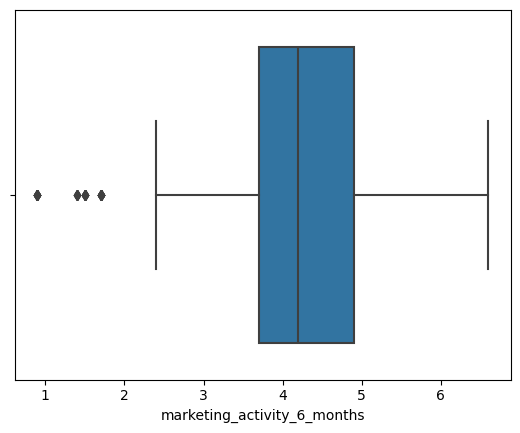

In [15]:
sns.boxplot(data=market_file, x='marketing_activity_6_months', hue='buying_activity')
None

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


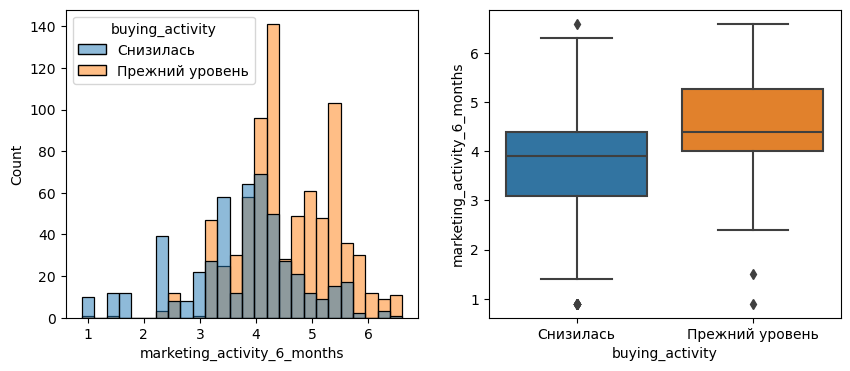

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


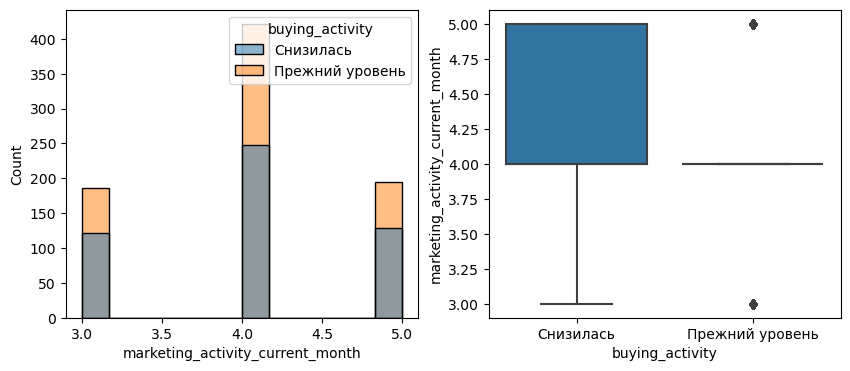

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


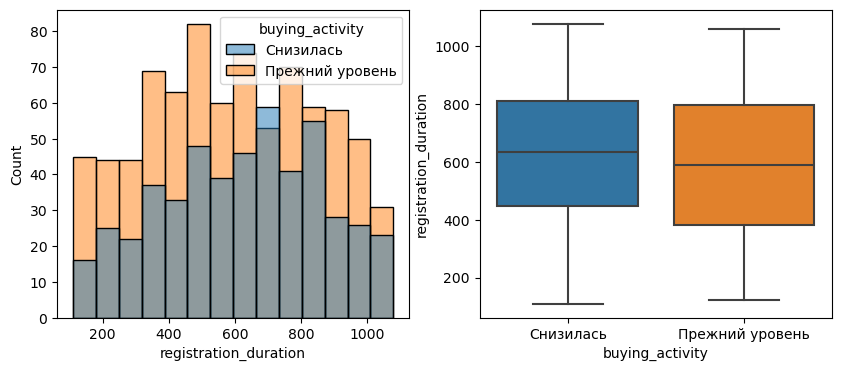

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


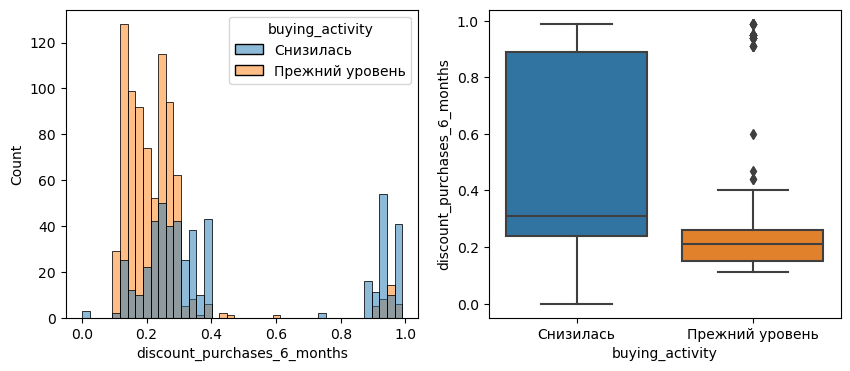

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


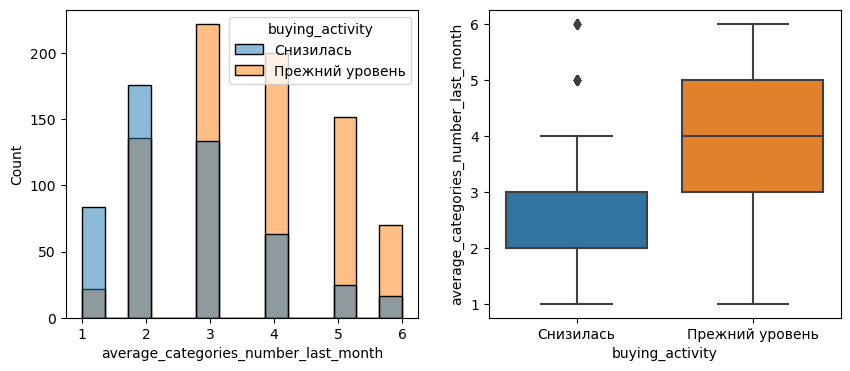

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


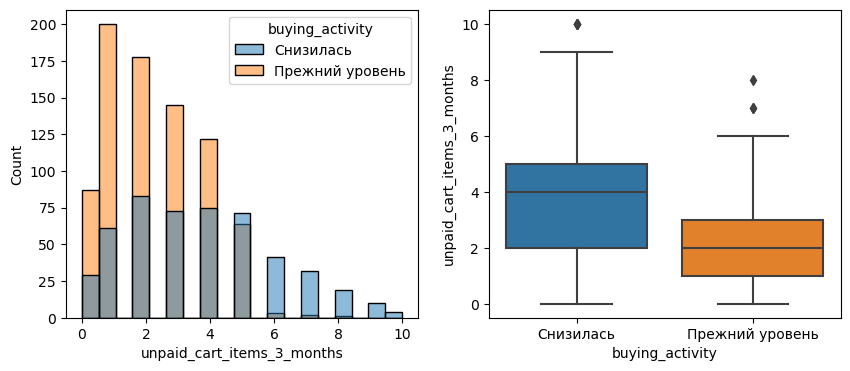

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


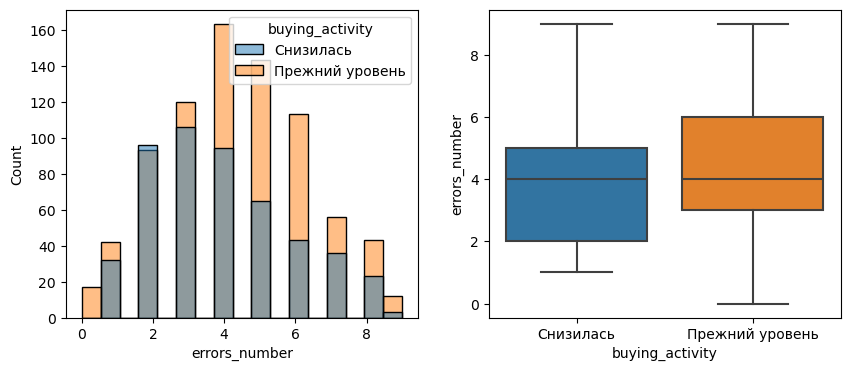

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


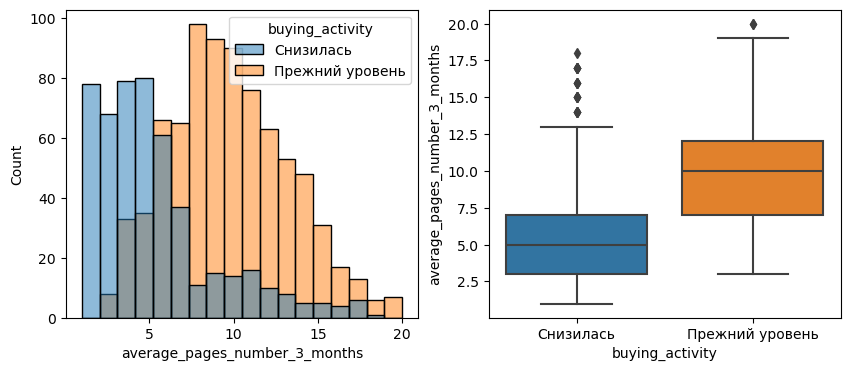

In [16]:
for num_column in ['marketing_activity_6_months',
                   'marketing_activity_current_month',
                   'registration_duration',
                   'discount_purchases_6_months',
                   'average_categories_number_last_month',
                   'unpaid_cart_items_3_months',
                   'errors_number',
                   'average_pages_number_3_months']:
    
    plt.rcParams['figure.figsize'] = 10, 4
    plt.subplot(1, 2, 1)
    sns.histplot(data=market_file, x=num_column, hue='buying_activity')
    plt.subplot(1, 2, 2)
    sns.boxplot(data=market_file, y=num_column, x='buying_activity')
    plt.show()

Построим круговые диаграммы для категориальных признаков:

Круговая диаграмма для признака "buying_activity"


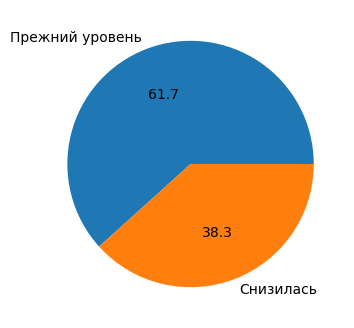

Круговая диаграмма для признака "service_type"


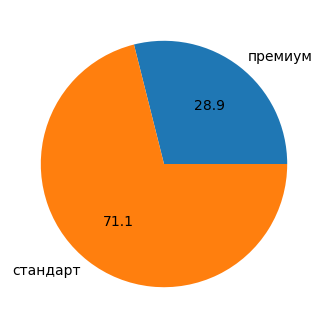

Круговая диаграмма для признака "popular_category_6_month"


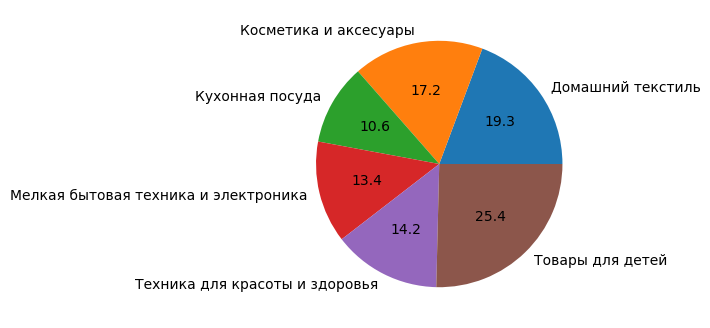

In [17]:
for cat_column in ['buying_activity', 'service_type', 'popular_category_6_month']:
    print(f'Круговая диаграмма для признака "{cat_column}"')
    plt.rcParams['figure.figsize'] = 4, 4
    x=market_file.groupby([cat_column])[cat_column].count()
    plt.pie(x=x, labels=x.index, autopct='%.1f')
    plt.show()

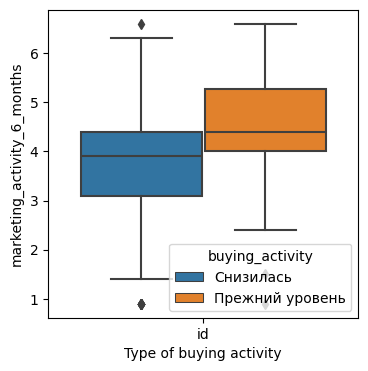

In [18]:
sns.boxplot(
   data=market_file.melt(id_vars=['buying_activity'], value_vars=['id'],
                var_name='Type of buying activity', value_name='Dosage'),
   x='Type of buying activity',
   y=market_file['marketing_activity_6_months'],
   hue='buying_activity')

None

In [19]:
market_file

,id,buying_activity,service_type,advertisement_permission,marketing_activity_6_months,marketing_activity_current_month,registration_duration,discount_purchases_6_months,popular_category_6_month,average_categories_number_last_month,unpaid_cart_items_3_months,errors_number,average_pages_number_3_months
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7


In [20]:
market_file.describe()

,id,marketing_activity_6_months,marketing_activity_current_month,registration_duration,discount_purchases_6_months,average_categories_number_last_month,unpaid_cart_items_3_months,errors_number,average_pages_number_3_months
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


**Заметим, что:**
- Количество маркетиниговых коммуникаций находится преимущественно в промежутке `от 2 до 5`, наиболее популярное количество - `4`. Значения данного показатель имеют `бимодальный вид`.
- Покупательская активность в среднем не снизилась у тех, на кого приходилось `больше маркетинговых коммуникаций`;
- Большинство представленных клиентов зарегестрировались на платформе от `1-1.5 лет назад`;
- Как правило, `20%` покупок клиентов - это покупки по акции, при этом есть клиенты, которые в более чем `80%` случаев берут товары по акции. Данный показатель имеет `бимодальное распределение`;
- У клиентов, покупающих `много товаров по акции`, есть склонность иметь `сниженную покупательскую активность`;
- Наиболее часто просматривают `3` категории при покупке того или иного товара. Показатель распределен номрально;
- Наиболее часто оставляют неоплаченными `2` или `3` товара. Показатель `распределён нормально со смещением влево`;
- Как правило, на клиента приходится `4-5` ошибок. Показатель распределён нормально;
- Покупатель как правило просматривает `6-8` страниц за визит. Показатель распределён `относительно нормально со смещением влево`;
- `70%` клиентов имеют стандартную подписку;
- Четверть `наиболее продаваемых` товаров - `товары для детей`. Также популярны `домашний тексить` и `косметика и аксессуары`.

Посмотрим на распределения значений параметров и основные статистические характеристики данных в датасете `market_money` в группировке **по периоду**:

In [21]:
market_money_pt = pd.pivot_table(
    market_money,
    index='id',
    columns='period',
    values='revenue',
    aggfunc='sum'
).reset_index()
market_money_pt.columns = ['id', 'revenue_previous', 'revenue_pre_previous', 'revenue_current']
market_money_pt.head()

,id,revenue_previous,revenue_pre_previous,revenue_current
0,215348,0.0,0.0,3293.1
1,215349,5216.0,4472.0,4971.6
2,215350,5457.5,4826.0,5058.4
3,215351,6158.0,4793.0,6610.4
4,215352,5807.5,4594.0,5872.5


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


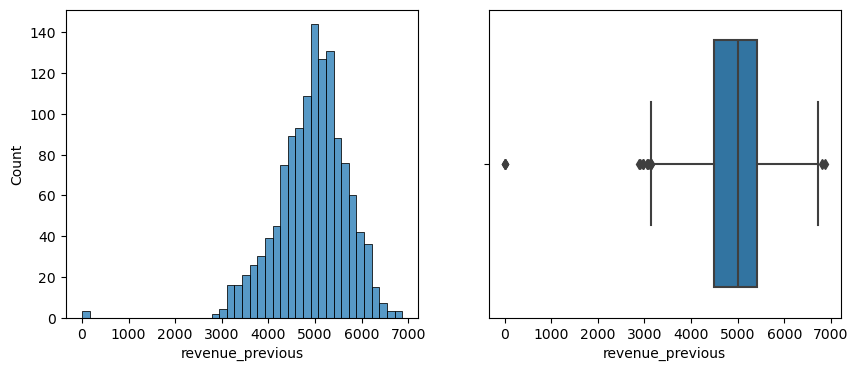

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


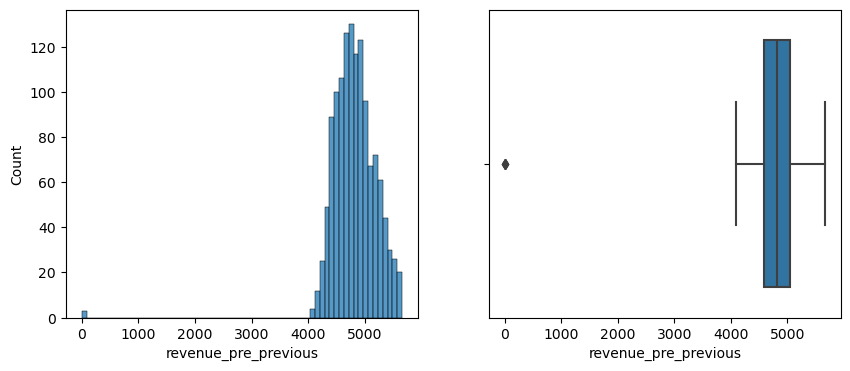

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


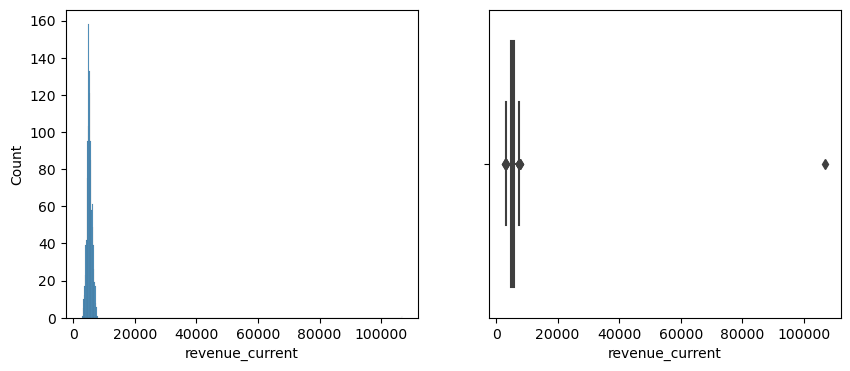

In [22]:
for num_column in ['revenue_previous', 'revenue_pre_previous', 'revenue_current']:
    plt.rcParams['figure.figsize'] = 10, 4
    plt.subplot(1, 2, 1)
    sns.histplot(data=market_money_pt, x=num_column)
    plt.subplot(1, 2, 2)
    sns.boxplot(data=market_money_pt, x=num_column)
    plt.show()

In [23]:
market_money_pt.describe()

,id,revenue_previous,revenue_pre_previous,revenue_current
count,1300.000000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4936.920385,4825.206923,5314.960846
std,375.421985,739.597997,405.979663,2939.708156
min,215348.000000,0.000000,0.000000,2758.700000
25%,215672.750000,4496.750000,4583.000000,4706.050000
50%,215997.500000,5005.000000,4809.000000,5179.950000
75%,216322.250000,5405.625000,5053.500000,5761.725000
max,216647.000000,6869.500000,5663.000000,106862.200000


Заметим, что:
- распределение значений выручки за текущий и предыдущие периоды имеет вид `нормального распределения`;
- в среднем выручка с покупателя составляет около `5 тыс. денежных единиц`
- в выручке за текущий месяц присутствует `выброс` - `106862` выручки против среднего значения в `5025`;
- в выручке за предыдущие периоды также есть выброс - `0`.

Посмотрим на распределения значений параметров и основные статистические характеристики данных в датасете `market_time` с группировкой по периоду:

In [24]:
market_time_pt = pd.pivot_table(
    market_time,
    index='id',
    columns='period',
    values='time_spent_minutes',
    aggfunc='sum'
).reset_index()
market_time_pt.columns = ['id', 'time_spent_minutes_previous', 'time_spent_minutes_current']
market_time_pt.head()

,id,time_spent_minutes_previous,time_spent_minutes_current
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


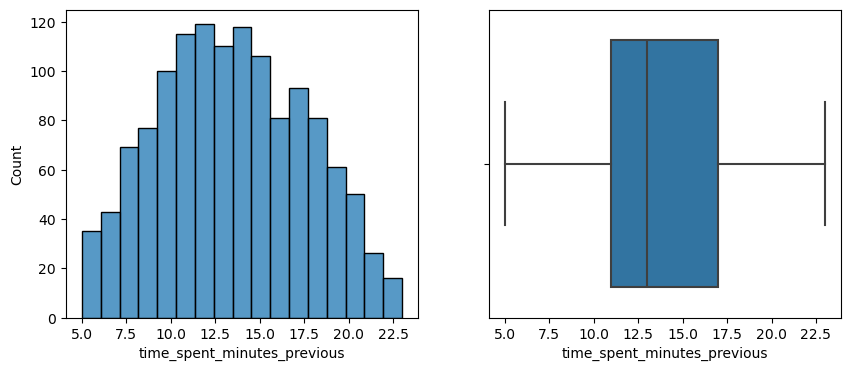

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


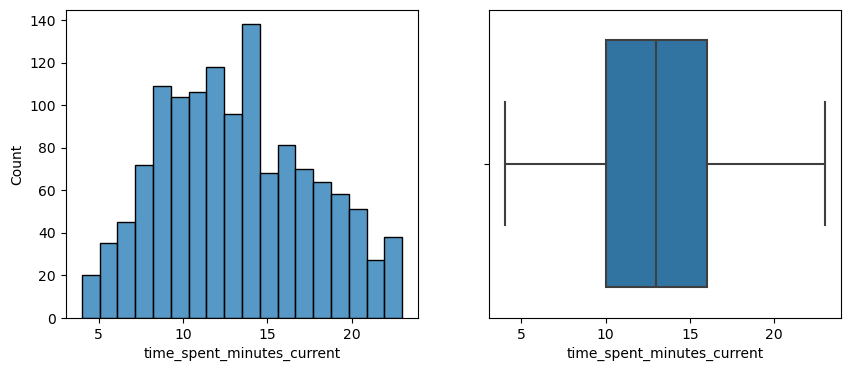

In [25]:
for num_column in ['time_spent_minutes_previous', 'time_spent_minutes_current']:
    plt.rcParams['figure.figsize'] = 10, 4
    plt.subplot(1, 2, 1)
    sns.histplot(data=market_time_pt, x=num_column)
    plt.subplot(1, 2, 2)
    sns.boxplot(data=market_time_pt, x=num_column)
    plt.show()

In [26]:
market_time_pt.describe()

,id,time_spent_minutes_previous,time_spent_minutes_current
count,1300.000000,1300.000000,1300.000000
mean,215997.500000,13.467692,13.204615
std,375.421985,3.932029,4.220589
min,215348.000000,5.000000,4.000000
25%,215672.750000,11.000000,10.000000
50%,215997.500000,13.000000,13.000000
75%,216322.250000,17.000000,16.000000
max,216647.000000,23.000000,23.000000


Заметим, что:
- в среднем клиенты проводят на платформе `13 минут`;
- данные имеют `нормальное распределение`;
- выбросов нет;

Посмотрим на распределения значений параметров и основные статистические характеристики данных в датасете `money`:

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


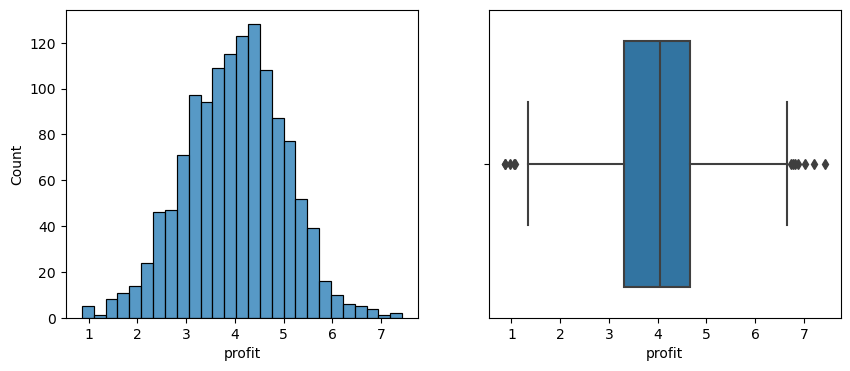

In [27]:
plt.rcParams['figure.figsize'] = 10, 4
plt.subplot(1, 2, 1)
sns.histplot(data=money, x='profit')
plt.subplot(1, 2, 2)
sns.boxplot(data=money, x='profit')
None

In [28]:
money.describe()

,id,profit
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


Заметим, что в среднем прибыль на одного клиента за месяц составляет `4 условных денежных единицы`.

## Объединение таблиц <a id="4"></a>

Объединим таблицы `market_file.csv`, `market_money.csv`, `market_time.csv` для дальнейшей работы.

In [29]:
df = market_file.merge(market_money_pt, on='id').merge(market_time_pt, on='id')
df.head()

,id,buying_activity,service_type,advertisement_permission,marketing_activity_6_months,marketing_activity_current_month,registration_duration,discount_purchases_6_months,popular_category_6_month,average_categories_number_last_month,unpaid_cart_items_3_months,errors_number,average_pages_number_3_months,revenue_previous,revenue_pre_previous,revenue_current,time_spent_minutes_previous,time_spent_minutes_current
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


Проверим на наличие пропусков:

In [30]:
df.isna().sum()

id                                      0
buying_activity                         0
service_type                            0
advertisement_permission                0
marketing_activity_6_months             0
marketing_activity_current_month        0
registration_duration                   0
discount_purchases_6_months             0
popular_category_6_month                0
average_categories_number_last_month    0
unpaid_cart_items_3_months              0
errors_number                           0
average_pages_number_3_months           0
revenue_previous                        0
revenue_pre_previous                    0
revenue_current                         0
time_spent_minutes_previous             0
time_spent_minutes_current              0
dtype: int64

Пропуски отсутствуют. Дале отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период:

In [31]:
df.query(('revenue_previous == 0') or ('revenue_pre_previous == 0') or ('revenue_current == 0'))

,id,buying_activity,service_type,advertisement_permission,marketing_activity_6_months,marketing_activity_current_month,registration_duration,discount_purchases_6_months,popular_category_6_month,average_categories_number_last_month,unpaid_cart_items_3_months,errors_number,average_pages_number_3_months,revenue_previous,revenue_pre_previous,revenue_current,time_spent_minutes_previous,time_spent_minutes_current
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
9,215357,Снизилась,стандарт,да,3.9,5,154,0.0,Техника для красоты и здоровья,3,3,9,5,0.0,0.0,5986.3,12,6
11,215359,Снизилась,стандарт,да,4.6,5,110,0.0,Домашний текстиль,4,2,4,2,0.0,0.0,4735.0,13,11


In [32]:
df = df.query('id != [215348, 215357, 215359]').reset_index().drop(['index'], axis=1)

## Корреляционный анализ данных <a id="5"></a>

Построим тепловую карту с корреляцией признаков. Воспользуемся для этого библиотекой `phik`. Она позволяет работать с разными типами данных, а также учитывать нелинейные зависимости.

interval columns not set, guessing: ['id', 'marketing_activity_6_months', 'marketing_activity_current_month', 'registration_duration', 'discount_purchases_6_months', 'average_categories_number_last_month', 'unpaid_cart_items_3_months', 'errors_number', 'average_pages_number_3_months', 'revenue_previous', 'revenue_pre_previous', 'revenue_current', 'time_spent_minutes_previous', 'time_spent_minutes_current']


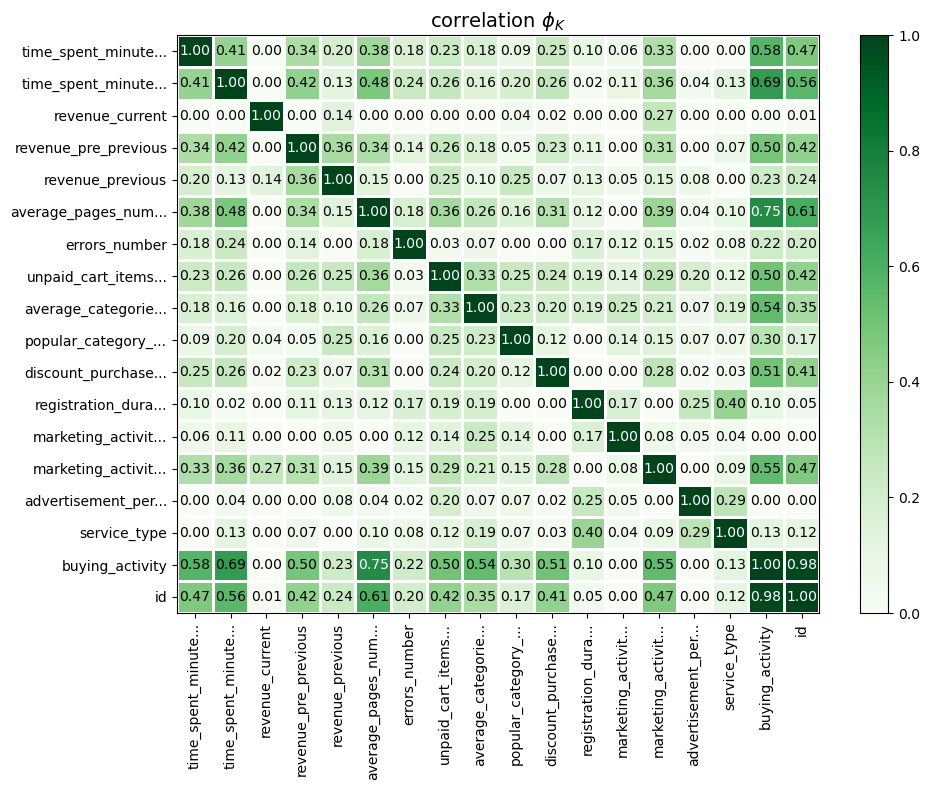

In [33]:
phik_overview = df.phik_matrix()
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1,
                        figsize=(10, 8))
plt.tight_layout()

Можно заметить, что с покупательской активностью коррелируют такие признаки, как проведенное за покупками время, среднее количество просмотренных страниц, среднее количество просмотренных категорий, покупки по акции и маркетинговая активность.

Вместе с тем, имеет место отметить небольшая мультиколлениарность в следующих парах признаков:
- затраченное время в этом месяце / в прошлом
- выручка за предыдущий / препредыдуший период
- потраченное время / количество просмотренных страниц.

Для наглядности, построим диаграммы рассеяния для количественных признаков:

In [34]:
df.columns

Index(['id', 'buying_activity', 'service_type', 'advertisement_permission',
       'marketing_activity_6_months', 'marketing_activity_current_month',
       'registration_duration', 'discount_purchases_6_months',
       'popular_category_6_month', 'average_categories_number_last_month',
       'unpaid_cart_items_3_months', 'errors_number',
       'average_pages_number_3_months', 'revenue_previous',
       'revenue_pre_previous', 'revenue_current',
       'time_spent_minutes_previous', 'time_spent_minutes_current'],
      dtype='object')

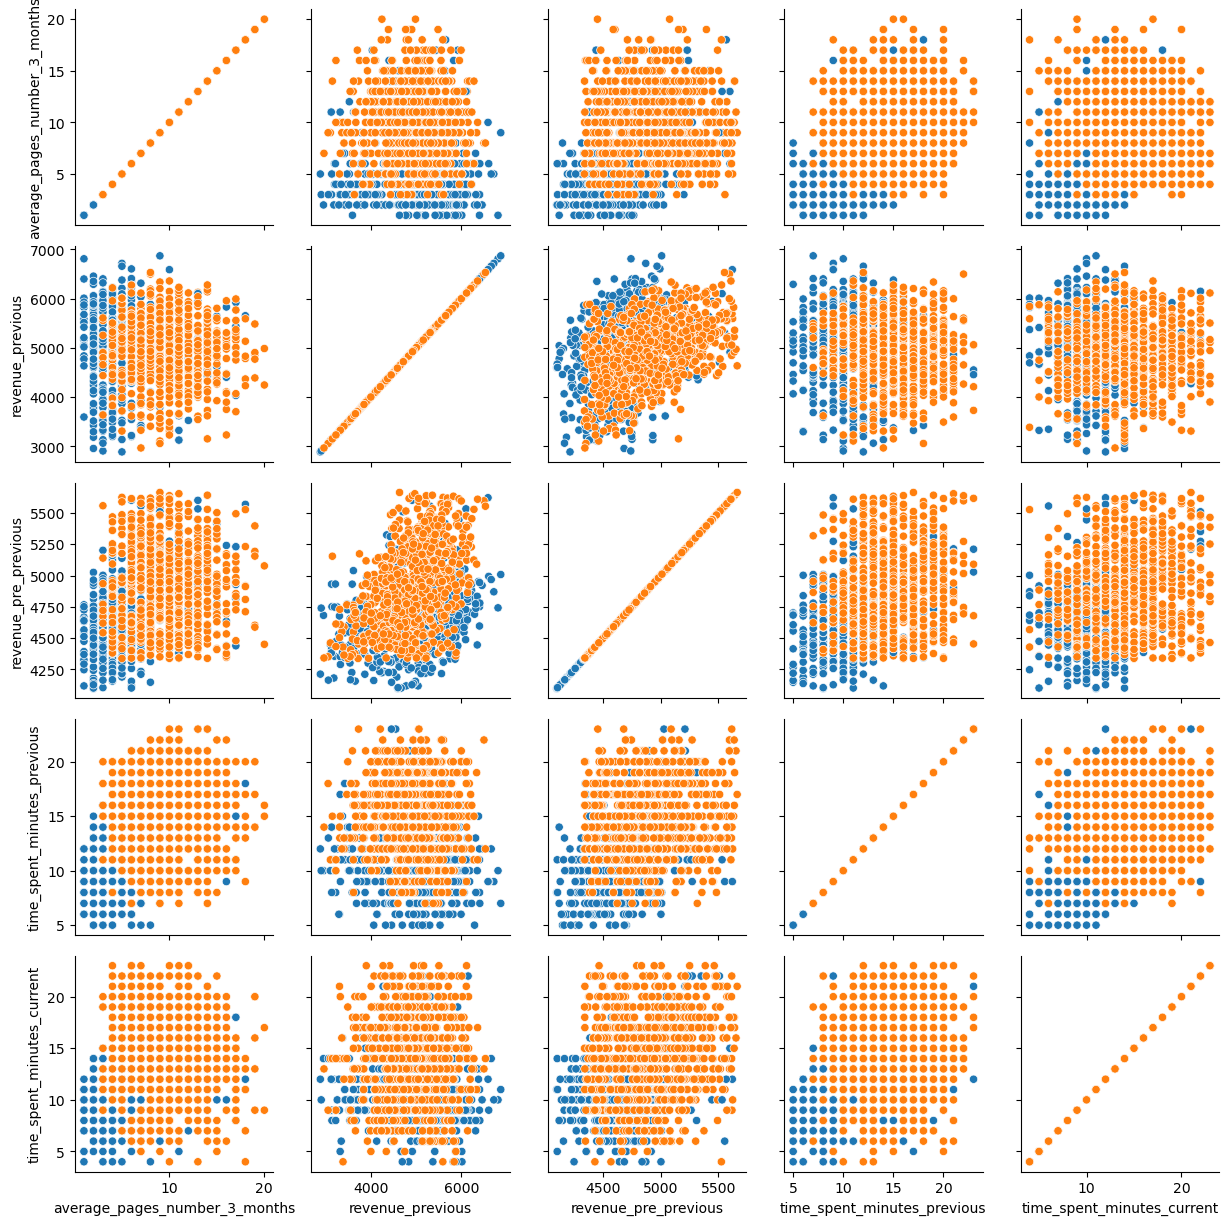

In [35]:
g = sns.PairGrid(df[['buying_activity', 'average_pages_number_3_months','revenue_previous', 'revenue_pre_previous',
       'time_spent_minutes_previous', 'time_spent_minutes_current']], hue = 'buying_activity')
g.map(sns.scatterplot)
None

На графиках можно визуально отметить слабую зависимость между вышеуказанными признаками. Попробуем поискать факторы которые описывает одновременно два разных множества (признака):
- Выручка за предыдущий & препредыдуший период => сумма выручки за предыдущие два периода
- Затраченное время в этом месяце / в прошлом => сумма затраченного времени за предыдущие два периода

/var/folders/_n/bj15yv052w14dr5hrs2kr2qm0000gn/T/ipykernel_41760/1729189857.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rev['revenue_sum'] = df['revenue_previous'] + df['revenue_pre_previous']
/var/folders/_n/bj15yv052w14dr5hrs2kr2qm0000gn/T/ipykernel_41760/1729189857.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rev['revenue_diff'] = df['revenue_previous'] - df['revenue_pre_previous']
/var/folders/_n/bj15yv052w14dr5hrs2kr2qm0000gn/T/ipykernel_41760/1729189857.py:5: SettingWithCopyWarnin

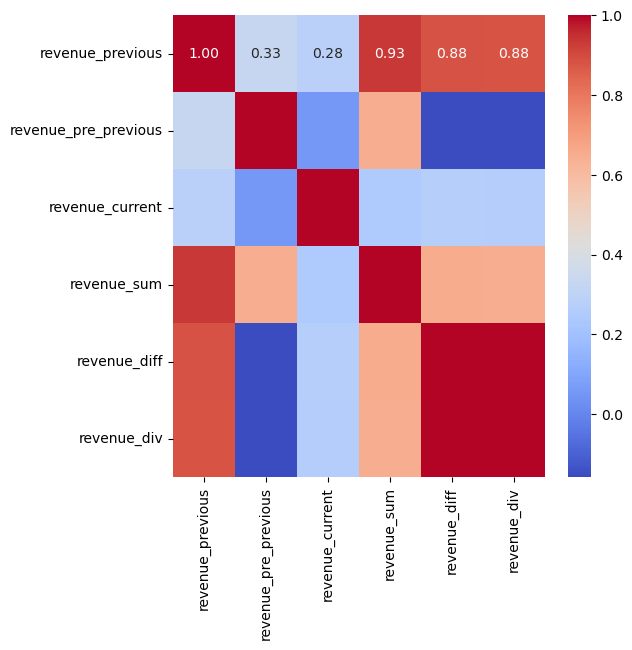

In [36]:
df_rev = df[['revenue_previous', 'revenue_pre_previous', 'revenue_current']]

df_rev['revenue_sum'] = df['revenue_previous'] + df['revenue_pre_previous']
df_rev['revenue_diff'] = df['revenue_previous'] - df['revenue_pre_previous']
df_rev['revenue_div'] = df['revenue_previous'] / df['revenue_pre_previous']

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(df_rev.corr(), annot=True, fmt=".2f", ax=ax, cmap='coolwarm')
None

Можно заметить, что сумма выручек за последние два периода очень сильно (0.92) коррелирует с выручкой за последний период и довольно сильно (0.65) коррелирует с выручкой за препредыдущий периоды. При этом данный интегрированный показатель слабо коррелирует (0.25) с выручкой за текущий период. Следовательно, можно сказать, что нельзя явно предсказать текущую выручку по предыдущим двум периодам.

/var/folders/_n/bj15yv052w14dr5hrs2kr2qm0000gn/T/ipykernel_41760/3568288371.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time['time_sum'] = df_time['time_spent_minutes_previous'] + df_time['time_spent_minutes_current']
/var/folders/_n/bj15yv052w14dr5hrs2kr2qm0000gn/T/ipykernel_41760/3568288371.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time['time_diff'] = df_time['time_spent_minutes_previous'] - df_time['time_spent_minutes_current']
/var/folders/_n/bj15yv052w14dr5hrs2kr2qm0000gn/T/ipyk

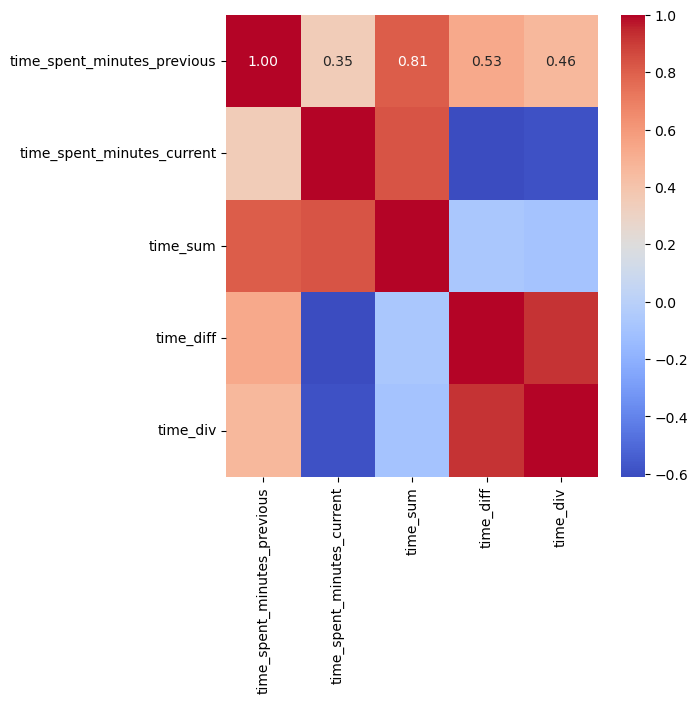

In [37]:
df_time = df[['time_spent_minutes_previous', 'time_spent_minutes_current']]

df_time['time_sum'] = df_time['time_spent_minutes_previous'] + df_time['time_spent_minutes_current']
df_time['time_diff'] = df_time['time_spent_minutes_previous'] - df_time['time_spent_minutes_current']
df_time['time_div'] = df_time['time_spent_minutes_previous'] / df_time['time_spent_minutes_current']

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(df_time.corr(), annot=True, fmt=".2f", ax=ax, cmap='coolwarm')
None

Можно заметить, что сумма потраченного за последние два периода времени очень сильно (0.81) коррелирует с потраченным за текущий период временем и так же сильно (0.83) коррелирует с потраченным за предыдущий период временем. Данный интегрированный показатель можно использовать вместо двух отдельных в случае линейного моделирования. С учетом того фактора нелинейности, присущего данным, не будем вводить новый интегрированный показатель.

<div class="alert"; style="border-left: 7px solid pink">

**Мини-вывод**
- С покупательской активностью коррелируют такие признаки, как проведенное за покупками время, среднее количество просмотренных страниц, среднее количество просмотренных категорий, покупки по акции и маркетинговая активность;
- Имеет место отметить небольшая мультиколлениарность в таких парах признаков как затраченное время в этом месяце / в прошлом, выручка за предыдущий / препредыдуший период, потраченное время / количество просмотренных страниц;
- Нельзя явно предсказать текущую выручку по предыдущим двум периодам;
- Сумма потраченного за последние два периода времени очень сильно (0.81) коррелирует с потраченным за текущий период временем и так же сильно (0.83) коррелирует с потраченным за предыдущий период временем.
</div>

In [38]:
df_rev = df[['revenue_current','revenue_previous', 'revenue_pre_previous', 'popular_category_6_month']]

df_rev['revenue_indicator'] = 2 * df_rev['revenue_previous'] - df_rev['revenue_pre_previous']

children_items = df_rev[df_rev['popular_category_6_month'] == 'Товары для детей']
home_textiles = df_rev[df_rev['popular_category_6_month'] == 'Домашний текстиль']
cosmetics_accessories = df_rev[df_rev['popular_category_6_month'] == 'Косметика и аксесуары']
kitchen_utensils = df_rev[df_rev['popular_category_6_month'] == 'Кухонная посуда']
beauty_health_equipment = df_rev[df_rev['popular_category_6_month'] == 'Техника для красоты и здоровья']
small_household_electronics = df_rev[df_rev['popular_category_6_month'] == 'Мелкая бытовая техника и электроника']

/var/folders/_n/bj15yv052w14dr5hrs2kr2qm0000gn/T/ipykernel_41760/4171975438.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rev['revenue_indicator'] = 2 * df_rev['revenue_previous'] - df_rev['revenue_pre_previous']


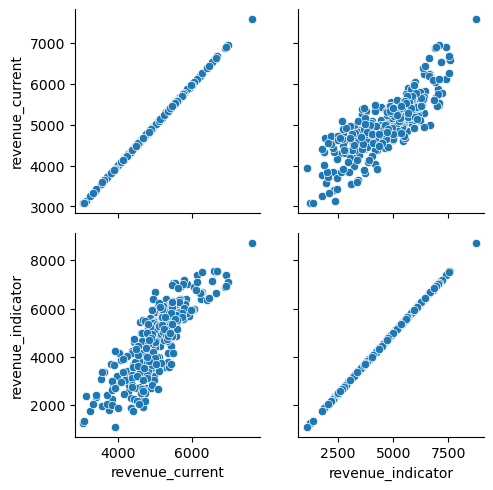

In [39]:
p = sns.PairGrid(children_items[['revenue_current','revenue_indicator']])
p.map(sns.scatterplot)
None

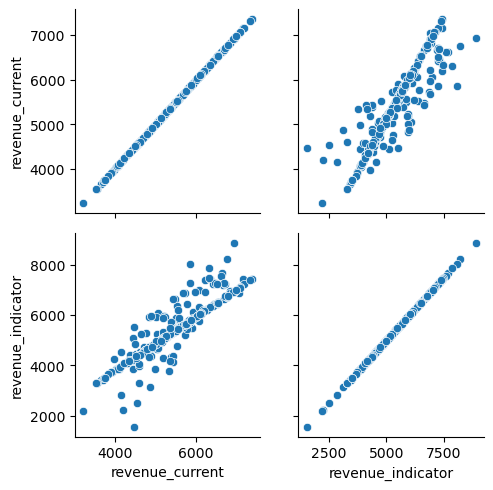

In [40]:
p = sns.PairGrid(home_textiles[['revenue_current','revenue_indicator']])
p.map(sns.scatterplot)
None

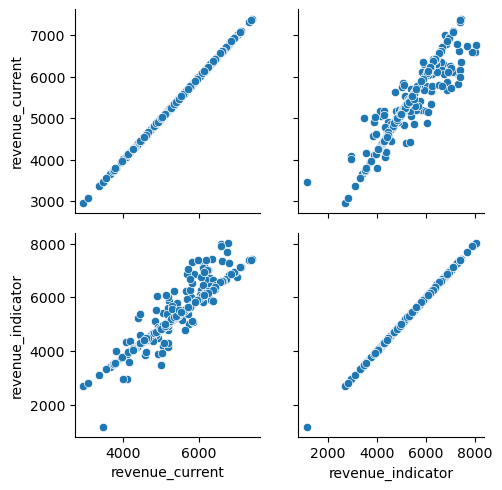

In [41]:
p = sns.PairGrid(cosmetics_accessories[['revenue_current','revenue_indicator']])
p.map(sns.scatterplot)
None

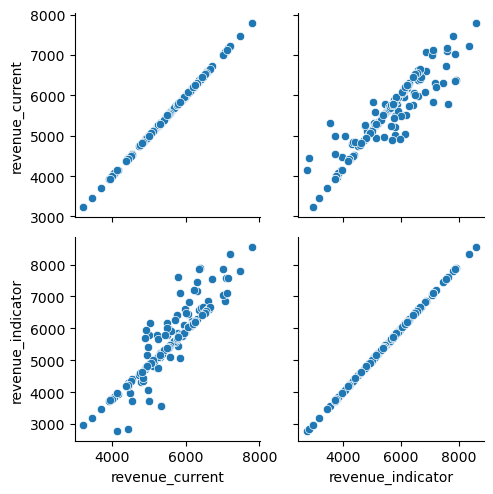

In [42]:
p = sns.PairGrid(kitchen_utensils[['revenue_current','revenue_indicator']])
p.map(sns.scatterplot)
None

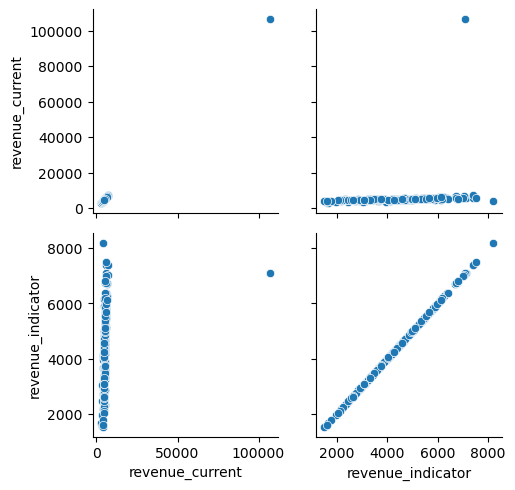

In [43]:
p = sns.PairGrid(beauty_health_equipment[['revenue_current','revenue_indicator']])
p.map(sns.scatterplot)
None

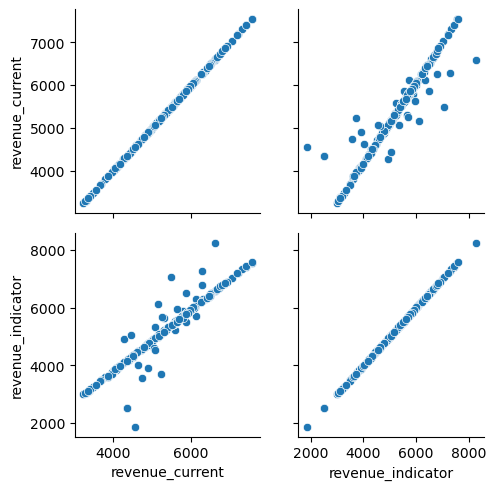

In [44]:
p = sns.PairGrid(small_household_electronics[['revenue_current','revenue_indicator']])
p.map(sns.scatterplot)
None

## Построение модели c помощью пайплайнов <a id="6"></a>

### 6.1 Подготовка данных к машинному обучению

Сперва закодируем целевый признак `buying_activity` таким образом, что "снизилось" => 1, а "не снизилось" => 0.

In [45]:
df.buying_activity = df.buying_activity.apply(lambda x: 1 if x == 'Снизилась' else 0)
df.head()

,id,buying_activity,service_type,advertisement_permission,marketing_activity_6_months,marketing_activity_current_month,registration_duration,discount_purchases_6_months,popular_category_6_month,average_categories_number_last_month,unpaid_cart_items_3_months,errors_number,average_pages_number_3_months,revenue_previous,revenue_pre_previous,revenue_current,time_spent_minutes_previous,time_spent_minutes_current
0,215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


Далее поделим данные на тренировочную и тестовые выборки:

In [46]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['buying_activity', 'id'], axis=1),
    df['buying_activity'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = df['buying_activity']
)

Обозначим, какие данные требуют масштабирования, а какие — кодирования:

In [47]:
ord_columns = ['service_type']

ohe_columns = ['advertisement_permission', 'popular_category_6_month']

num_columns = [
    'marketing_activity_6_months',
    'marketing_activity_current_month',
    'registration_duration',
    'discount_purchases_6_months',
    'average_categories_number_last_month',
    'unpaid_cart_items_3_months',
    'errors_number',
    'average_pages_number_3_months',
    'revenue_previous',
    'revenue_pre_previous',
    'revenue_current',
    'time_spent_minutes_previous',
    'time_spent_minutes_current'
]

Создадим пайплайны для кодирования категориальных признаков:

In [48]:
ohe_pipe = Pipeline(
    [
        (
            'ohe', OneHotEncoder(drop='first', sparse_output=False)
        )
    ]
)

In [49]:
ord_pipe = Pipeline(
    [
        (
            'ord', OrdinalEncoder(
                categories = [['стандарт', 'премиум']],
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        )
    ]
)

Объеденим этапы по кодированию и масштабированию:

In [50]:
data_preprocessor=ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

Создадим итоговый пайплайн для обучения модели:

In [51]:
pipe_final=Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

Переберём разные методы масштабирования:

In [52]:
param_grid = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    'models': [
        DecisionTreeClassifier(random_state=RANDOM_STATE),
        KNeighborsClassifier(),
        SVC(random_state=RANDOM_STATE, probability=True),
        LogisticRegression(random_state=RANDOM_STATE)
    ]
}

In [53]:
grid = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv = 5,
    scoring = 'roc_auc',
    n_jobs=-1
)

### 6.2 Обучение данных

Обучим созданный ранее пайплайн на тренировочных данных:

In [54]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse_output=False))]),
                                                                         ['advertisement_permission',
                                                                          'popular_category_6_month']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('ord',
                                                                                          OrdinalEncoder(categories=[['стандарт',
                                                                                                                      'премиум']],
                                                                                                         handle_unknown=...
                                                                          'time_spent_minutes_previous',
                                                                          'time_spent_minutes_current'])])),
                                       ('models',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'models': [DecisionTreeClassifier(random_state=42),
                                    KNeighborsClassifier(),
                                    SVC(probability=True, random_state=42),
                                    LogisticRegression(random_state=42)],
                         'preprocessor__num': [StandardScaler(),
                                               MinMaxScaler()]},
             scoring='roc_auc')

### 6.3 Тестирование данных

In [55]:
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['advertisement_permission',
                                                   'popular_category_6_month']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                                                               'премиум']],
                                     

Выведем метрику качества модели. Оптимальной метрикой представляется ROC-AUC, поскольку она является всеохватывающей метрикой качества классификации и учитывает работу модели при всех возможных значениях порогов.

In [56]:
print('Метрика ROC-AUC для лучшей модели:\n', grid.best_score_)

Метрика ROC-AUC для лучшей модели:
 0.914311783684511


Метрика имеет высокое значение, что говорит о хорошем качестве модели. Посмотрим, какая именно модель и гиперпараметр наиболее точны для предсказания целевого признака:

In [57]:
print(*pd.DataFrame(grid.cv_results_)[pd.DataFrame(grid.cv_results_)['rank_test_score']==1].params)

{'models': SVC(probability=True, random_state=42), 'preprocessor__num': StandardScaler()}


Наиболее точна модель SVC с гиперпараметром масштабирования StandardScaler.

Протестируем модель на тестовой выборке:

In [58]:
preds = grid.predict_proba(X_test)

roc_auc = roc_auc_score(y_test, preds[:,1])
print('ROC-AUC = ', roc_auc.round(2))

ROC-AUC =  0.92


На тестовой выборке качество модели высоко и равняется `~0.92`.

## Анализ важности признаков <a id="7"></a>

Оценим важность признаков. Для лучшей модели оценить нет возможность ввиду специфики работы модели.

In [59]:
X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_train),
    columns=data_preprocessor.get_feature_names_out()
)

X_test_p = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out()    
)

In [60]:
svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train_p, y_train)

y_pred_svm =svm.predict(X_test_p)
roc_auc_score(y_test, y_pred_svm)

0.8883004333172845

Для модели DecisionTreeClassifier посмотрим на важность признаков с помощью метода SHAP. Проанализируем важность признаков и для модели линейной регрессии.

In [61]:
DRC = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth = 10)
DRC.fit(X_train_p, y_train)
y_pred_DRC = DRC.predict(X_test_p)
accuracy_score(y_test, y_pred_DRC)

0.8369230769230769

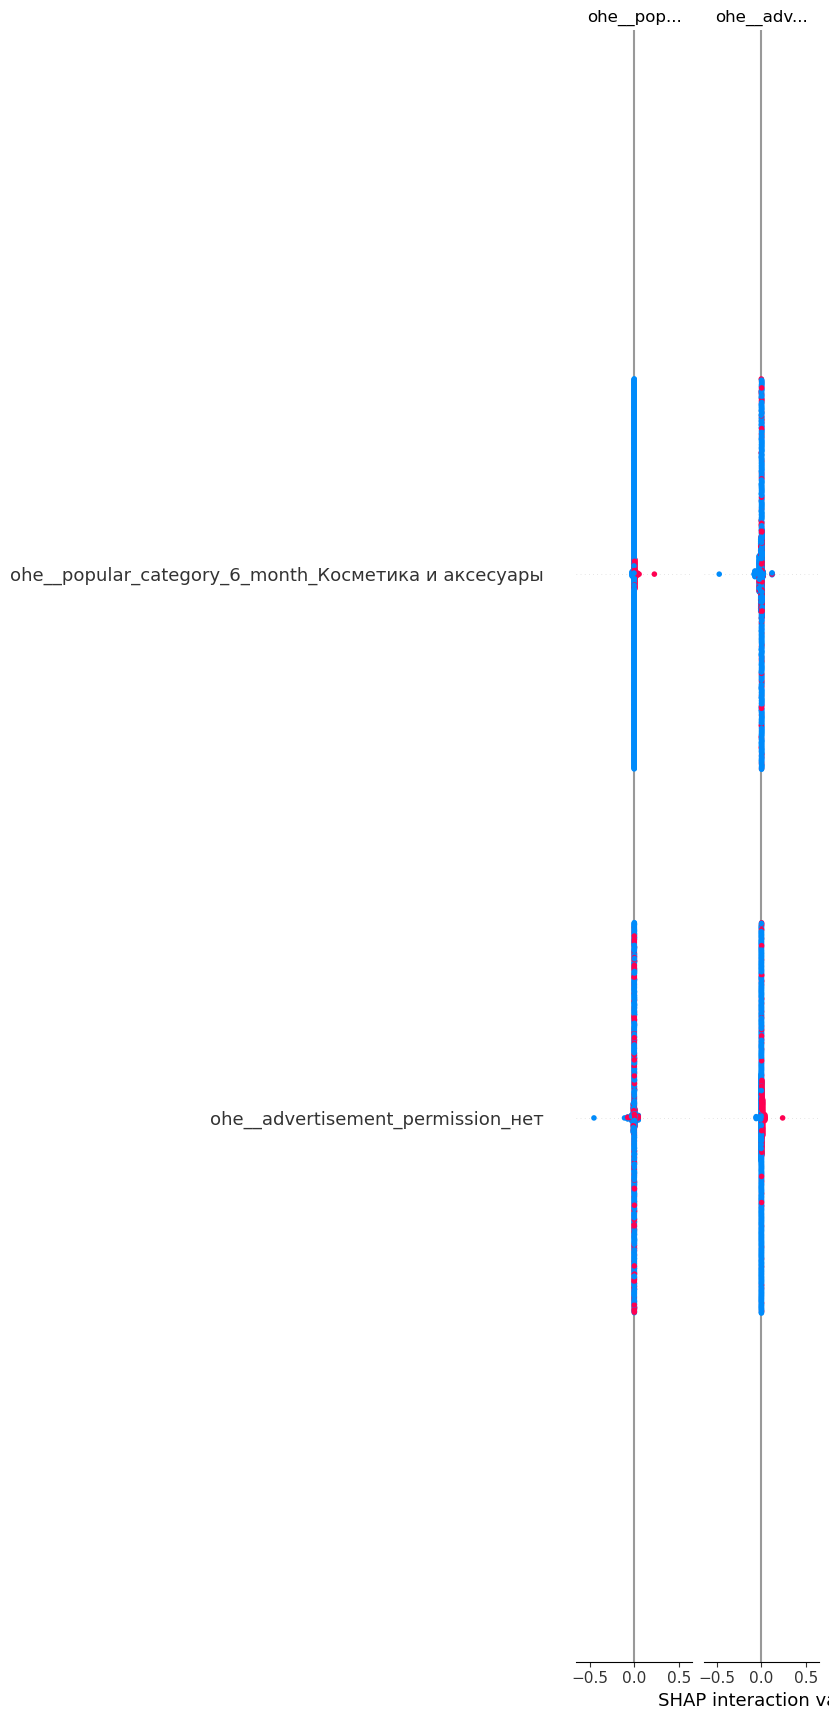

In [62]:
shap_test = shap.TreeExplainer(DRC).shap_values(X_train_p)
shap.summary_plot(shap_test, X_train_p, max_display=25, plot_size=None)

Как видим, в модели `DecisionTreeClassifier` наиболее важными признаками являбтся количество посещенных страниц, потраченное время, количество покупок по скидке, выручка с клиента, маркетинговая активность за последние 6 месяцев. Наименее важным признаков является разрешение на рекламу, популряная категория.

In [63]:
LR = LogisticRegression(random_state=RANDOM_STATE)
LR.fit(X_train_p, y_train)
y_pred_LR = LR.predict(X_test_p)
accuracy_score(y_test, y_pred_LR)

0.8984615384615384

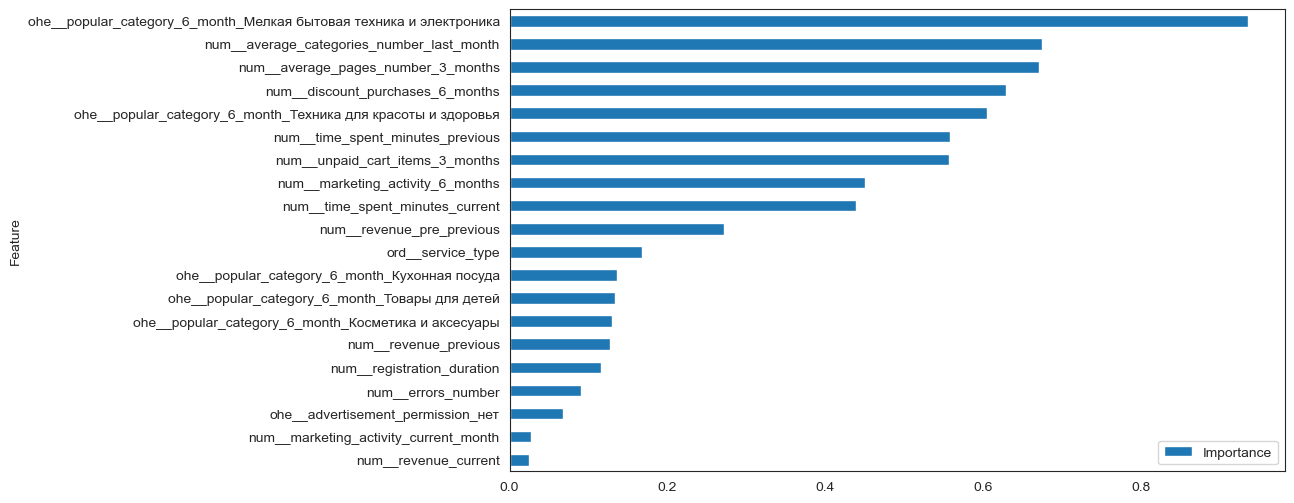

In [64]:
coefficients = LR.coef_[0]
sns.set_style('white')
feature_importance = pd.DataFrame({'Feature': X_train_p.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
None

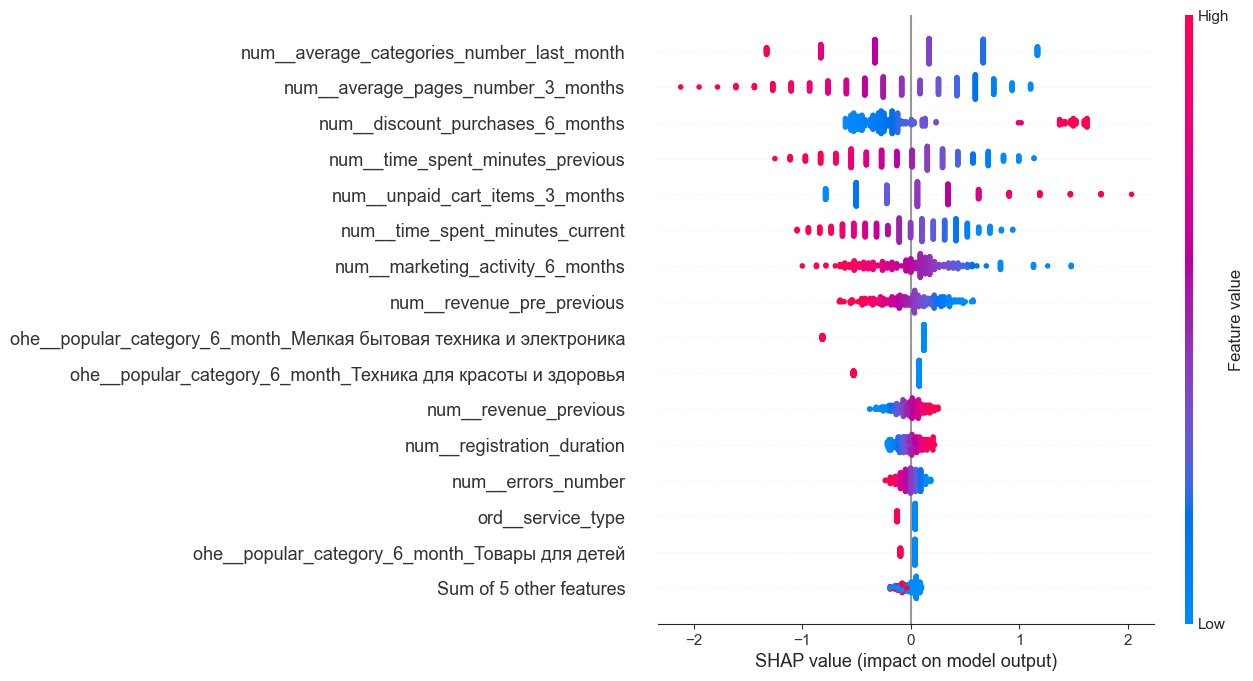

In [65]:
explainer = shap.LinearExplainer(LR, X_test_p)
shap_values = explainer(X_test_p)
shap.plots.beeswarm(shap_values, max_display=16)

В модели `Logistic Regression` наиболее значимыми признаками являются факт наличия мелкой бытовой техники или техники для красоты и здоровья как популярной категории, среднее количество просмотренных страниц, количество покупок по скидке, среднее количество просматриваемых категорий. Наименее значимыми признаками являются маркетинговая активность в текущем месяце, выручка клиента, тип сервиса.

Посмотрим как изменение признака на единицу влияют на вероятность отнесения к классу:

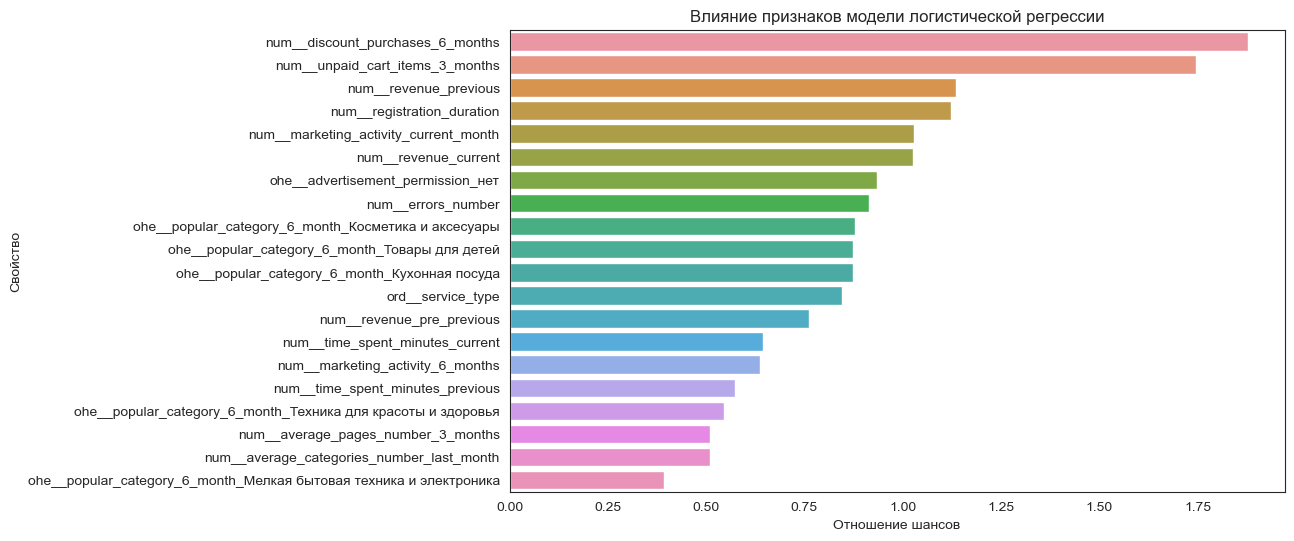

In [66]:
coefficients = LR.coef_[0]
feature_names = X_train_p.columns

coef_df = pd.DataFrame({'Свойство': feature_names, 'Коэффициент': coefficients})
coef_df['Отношение шансов'] = np.exp(coef_df['Коэффициент'])

coef_df = coef_df.sort_values(by='Отношение шансов', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Отношение шансов', y='Свойство', data=coef_df)
plt.title('Влияние признаков модели логистической регрессии')
plt.xlabel('Отношение шансов')
plt.ylabel('Свойство')
plt.show()

Как можно заметить, у таких признаков, как `num__discount_purchases_6_months` и `num__unpaid_cart_items_3_months` более существенное влияние  на вероятность снижения покупательской активности.

<div class="alert"; style="border-left: 7px solid pink">

**Мини-вывод**
- В модели DecisionTreeClassifier значимы количество посещенных страниц, потраченное время, количество покупок по скидке, выручка с клиента, маркетинговая активность за последние 6 месяцев. Наименее значимы разрешение на рекламу, популряная категория.
- В модели Linear Regression значимы популярная категория, среднее количество просмотренных страниц, количество покупок по скидке, среднее количество просматриваемых категорий. Наименее значимыми признаками являются маркетинговая активность в текущем месяце, выручка клиента, тип сервиса.
- *Таким образом, важны признаки, связанные с тем, что клиент смотрит и как долго он это смотрит.* Это позволяет заключить, что при принятии бизнес-решений стоит учитывать клиентский путь клиента, его UI/UX опыт, а также разнообразие ассортимента продукции определенных категорий. Всё это влияет на время нахождения клиента на сайте, а значит и на целевую метрику.
</div>

## Сегментация клиентов <a id="8"></a>

Клиентов можно сегментировать различным образом. С учетом проделанной работы можно выделить следующие классификации:

**По финансовому аспекту:**
- Низкоприбыльные клиенты
- Среднеприбыльные клиенты
- Высокоприбыльные клиенты

**По предпочитаемым категориям:**
- Клиенты, покупающие товары для себя (косметика, аксессуары)
- Клиенты, покупающие технику (товары с длинным жизненным циклом) и др.

**По продуктовому поведению:**
- Клиенты, часто покупающие товары по акции
- Клиенты, редко покупающие товары по акции

**По коммуникации с клиентом:**
- Клиенты, имеющие премиум подписку и разрешение на рекламу
- Клиенты, имеющие стандартную подписку без разрешения на рекламу и др.

### Углубленный анализ одного из сегментов

Рассмотрим следующий сегмент: **"Покупатели с высокой долей акционных покупок и склонностю к снижению покупательской активности"**

Ранее отмечалась отдельная группа клиентов, у которых большинство покупок - это товары по акции. Примечательно, что среди них большинство склонные к скиженной покупательской активности. В связи с этим представляется важно выделить данный сегмент отдельно, проанализировать и предложить рекомендации.

Для начала добавим к общему датафрейму инфорамацию о среднемесячной прибыли с клиента:

In [67]:
df_full = df.merge(money, on='id')
df_full.head()

,id,buying_activity,service_type,advertisement_permission,marketing_activity_6_months,marketing_activity_current_month,registration_duration,discount_purchases_6_months,popular_category_6_month,average_categories_number_last_month,unpaid_cart_items_3_months,errors_number,average_pages_number_3_months,revenue_previous,revenue_pre_previous,revenue_current,time_spent_minutes_previous,time_spent_minutes_current,profit
0,215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,4.16
1,215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,3.13
2,215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,4.87
3,215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,4.21
4,215353,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,3.95


Построим повторно график распределения признака "discount_purchases_6_months" в разрезе покупательской активности:

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


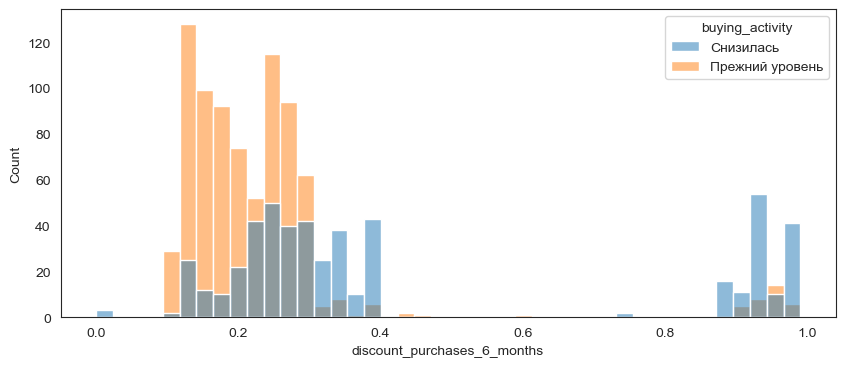

In [68]:
plt.rcParams['figure.figsize'] = 10, 4
plt.subplot(1, 1, 1)
sns.histplot(data=market_file, x='discount_purchases_6_months', hue='buying_activity')
plt.show()

Отфильтруем таблицу, оставив только представителей этого сегмента:

In [69]:
df_segment = df_full.query(('buying_activity == 1 & discount_purchases_6_months > 0.8'))
df_segment.describe()

,id,buying_activity,marketing_activity_6_months,marketing_activity_current_month,registration_duration,discount_purchases_6_months,average_categories_number_last_month,unpaid_cart_items_3_months,errors_number,average_pages_number_3_months,revenue_previous,revenue_pre_previous,revenue_current,time_spent_minutes_previous,time_spent_minutes_current,profit
count,132.000000,132.0,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000
mean,215580.272727,1.0,3.609848,3.962121,613.878788,0.944167,2.628788,3.992424,4.060606,4.757576,4956.348485,4652.916667,6033.625758,10.378788,10.568182,3.854545
std,152.155961,0.0,1.105563,0.681325,231.246144,0.033316,1.231925,2.527698,1.860631,2.505326,811.496737,253.893048,8886.741324,2.930571,2.937500,0.964137
min,215351.000000,1.0,0.900000,3.000000,147.000000,0.890000,1.000000,0.000000,1.000000,1.000000,3146.000000,4098.000000,3232.200000,5.000000,4.000000,1.330000
25%,215457.250000,1.0,3.000000,3.750000,458.000000,0.930000,2.000000,2.000000,3.000000,3.000000,4434.625000,4463.500000,4643.425000,8.000000,9.000000,3.177500
50%,215567.000000,1.0,3.900000,4.000000,627.000000,0.940000,2.000000,4.000000,4.000000,4.000000,5113.250000,4661.500000,5293.650000,10.000000,10.000000,4.010000
75%,215694.500000,1.0,4.325000,4.000000,795.500000,0.980000,3.000000,6.000000,5.000000,6.000000,5546.875000,4809.000000,5882.175000,12.000000,12.000000,4.420000
max,215940.000000,1.0,5.700000,5.000000,1064.000000,0.990000,6.000000,10.000000,8.000000,14.000000,6716.500000,5532.000000,106862.200000,19.000000,19.000000,6.730000


В данных 132 представителяд данного сегмента. В среднем, прибыли от него меньше, чем в среднем по всем клиентам. Они также тратят меньше времени на сайте.

Посмотрим на структуру покупок выделнного клиентского сегмента в сравнении с данными по всем клиентам:

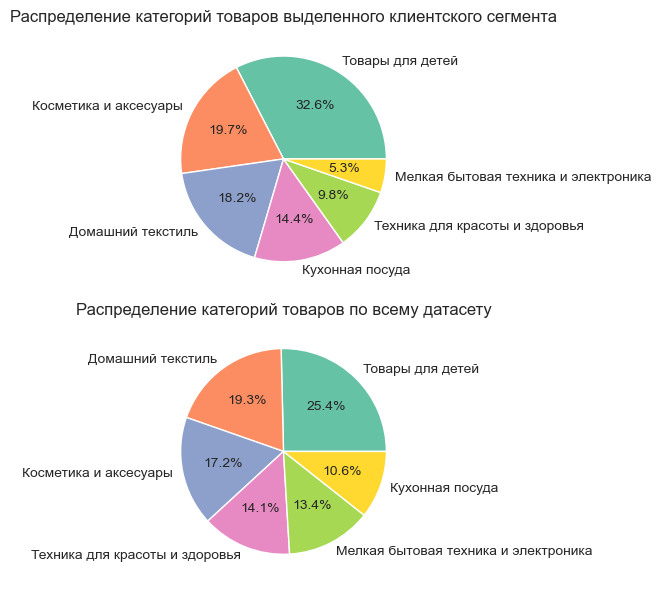

In [70]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

axes[0].pie(
    x=df_segment['popular_category_6_month'].value_counts(),
    labels=df_segment['popular_category_6_month'].value_counts().index,
    autopct='%1.1f%%',
    colors=plt.cm.Set2.colors
)
axes[0].set_title('Распределение категорий товаров выделенного клиентского сегмента')

axes[1].pie(
    x=df_full['popular_category_6_month'].value_counts(),
    labels=df_full['popular_category_6_month'].value_counts().index,
    autopct='%1.1f%%',
    colors=plt.cm.Set2.colors
)
axes[1].set_title('Распределение категорий товаров по всему датасету')

plt.tight_layout()

plt.show()

Заметим, что представители этого сегмента чаще покупают `товары для детей` и `домашний текстиль`. Вместе с тем, доля `мелкой бытовой техники и электроники` меньше почти в 3 раза, чем в среднем по всему датасету, а `кухонной посуды` и `техники для красоты и здоровья` у этого сегмента меньше на `~50%` чем чем в среднем по всем данным.

Учитывая этот факт, а также то, что модели машинного обучения показали важность таких признаков как наличие мелкой бытовой техники или техники для красоты и здоровья как популярной категории и количество покупок по скидке, можно сформулировать следующую рекомендацию:

<div class="alert"; style="border-left: 7px solid blue">

**Рекомендация №1. Стимулировать покупки товаров "проседающих категорий":**
    
Стимулировать клиентов покупать товары из категорий "мелкой бытовой техники и электроники", "кухонной посуды" и "техники для красоты". Для этого можно предложить для клиентов этого сегмента скидки на данные категории товаров.

</div>

На основе выводов модели машинного обучения, которая выделила важность таких признаков, как количество посещенных страниц и затраченное на сайте время, можно сформулировать еще следующие рекомендации для интернет-магазина:

<div class="alert"; style="border-left: 7px solid blue">

**Рекомендация №2. Оптимизировать пользовательский интерфейс (UI/UX):**
    
Необходимо обеспечить легкий и интуитивно понятный интерфейс, чтобы пользователи могли легко найти необходимую информацию, а также размещать ключевые продукты и предложения на стратегически важных страницах.

**Рекомендация №3. Стимулировать взаимодействие:**
    
Представляется эффективным создавать привлекательные и интересные контентные блоки для увеличения времени, проведенного на сайте, и использовать качественные изображения и описания товаров для привлечения внимания.

**Рекомендация №4. Анализировать и оптимизировать воронку продаж:**

Необходимо тщательнее изучить маршрут пользователей от первого посещения до завершения покупки, что выявить более детальные признаки, влияющие на покупку
    
</div>

Посмотрим, как соотносятся различная маркетинговая активность, которая приходится на клиентов, и их покупательская способность:

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


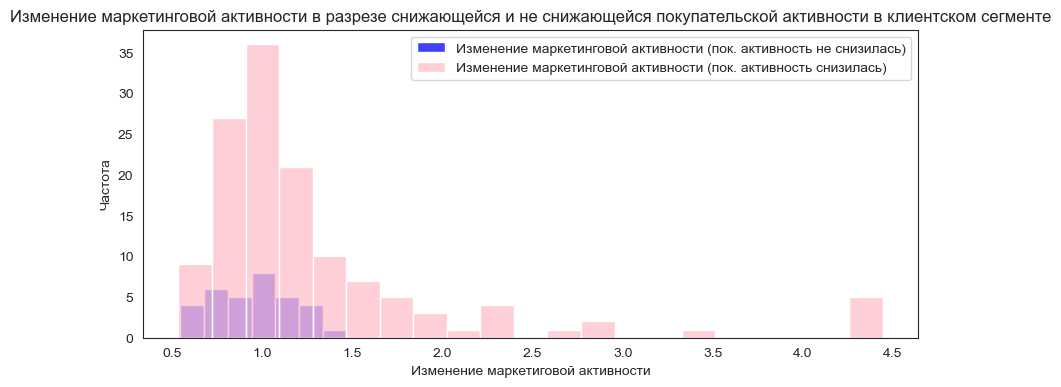

In [71]:
x = df_full.query(('discount_purchases_6_months > 0.8  & buying_activity == 0'))
y = df_full.query(('discount_purchases_6_months > 0.8  & buying_activity == 1'))

fig, ax = plt.subplots()

sns.histplot(data=x['marketing_activity_current_month']/x['marketing_activity_6_months'], color='blue', label='Изменение маркетинговой активности (пок. активность не снизилась)', ax=ax)
sns.histplot(data=y['marketing_activity_current_month']/y['marketing_activity_6_months'], color='pink', label='Изменение маркетинговой активности (пок. активность снизилась)', ax=ax)

ax.set_xlabel('Изменение маркетиговой активности')
ax.set_ylabel('Частота')
ax.legend()
ax.set_title('Изменение маркетинговой активности в разрезе снижающейся и не снижающейся покупательской активности в клиентском сегменте')

plt.show()

Заметим, что среди клиентов, чья покупательская активность не снизилась, маркетинговая активность не выростала более чем в 1.5 раза. Вместе с тем у многих клиентов со сниженной покупательской активностью количество маркетинговых коммуникаций увеличиволось более чем в 2, 3 и даже 4 раза. На основании этого можно выдвинуть следующую рекомендацию:

<div class="alert"; style="border-left: 7px solid blue">

**Рекомендация №5. Пересмотреть маркетинговую политику:**
    
Не увеличивать без четкого понимания целей количество маркетинговых коммуникаций, приходящихся на клиента, более, чем в 1.5 раза.

</div>

Посмотрим на покупательскую активность клиентов данного сегмента в зависимости от типа подписки:

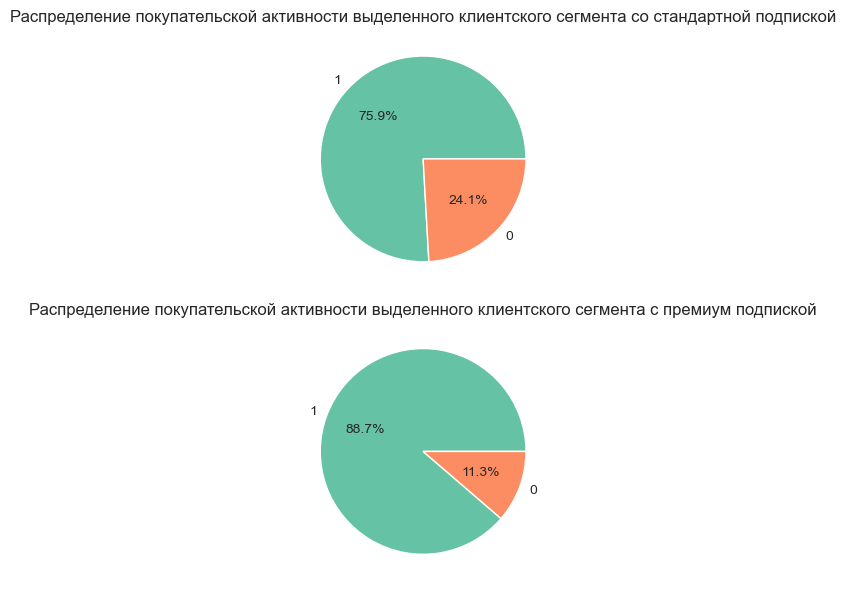

In [72]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

axes[0].pie(
    x=df_full.query(('discount_purchases_6_months > 0.8  & service_type == "стандарт"'))['buying_activity'].value_counts(),
    labels=df_full.query(('discount_purchases_6_months > 0.8  & service_type == "стандарт"'))['buying_activity'].value_counts().index,
    autopct='%1.1f%%',
    colors=plt.cm.Set2.colors
)
axes[0].set_title('Распределение покупательской активности выделенного клиентского сегмента со стандартной подпиской')

axes[1].pie(
    x=df_full.query(('discount_purchases_6_months > 0.8  & service_type == "премиум"'))['buying_activity'].value_counts(),
    labels=df_full.query(('discount_purchases_6_months > 0.8  & service_type == "премиум"'))['buying_activity'].value_counts().index,
    autopct='%1.1f%%',
    colors=plt.cm.Set2.colors
)
axes[1].set_title('Распределение покупательской активности выделенного клиентского сегмента с премиум подпиской')

plt.tight_layout()

plt.show()

Заметим, что среди клиентов с премиум подпиской доля тех, чья покупательская активность снизилась, больше, чем среди тех, у кого подписка стандартная. С учетом этого можно предложить следующие рекомендации:

<div class="alert"; style="border-left: 7px solid blue">

**Рекомендация №6. Персонализированные предложения для премиум-подписчиков:**
    
Необходимо разработать индивидуальные предложения и скидки для клиентов с премиум подпиской, чтобы удерживать их интерес.

**Рекомендация №7. Эксклюзивный контент и услуги:**
    
Необходимо предоставлять премиум-подписчикам доступ к эксклюзивному контенту, акциям или мероприятиям, а также внедрять дополнительные услуги или функции, доступные только для пользователей с премиум подпиской.
    
**Рекомендация №8. Сбор обратной связи:**
    
Рекомендуется проводить опросы и собирать обратную связь с премиум клиентов, чтобы лучше понять их ожидания и предпочтения.
    
**Рекомендация №9. Бонусы за лояльность:**
    
Представляется полезным ввести программу лояльности с дополнительными бонусами и наградами для клиентов с премиум подпиской.
    
</div>

В конце концов посмотрим, как соотносятся прибыль с клиентов и то, есть ли у них согласие на рекламу:

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


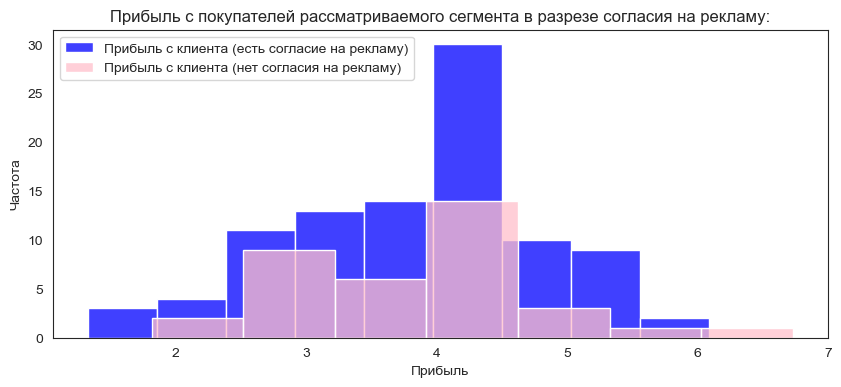

In [73]:
x = df_full.query(('discount_purchases_6_months > 0.8  & buying_activity == 1 & advertisement_permission == "да"'))
y = df_full.query(('discount_purchases_6_months > 0.8  & buying_activity == 1 & advertisement_permission == "нет"'))

fig, ax = plt.subplots()

sns.histplot(data=x['profit'], color='blue', label='Прибыль с клиента (есть согласие на рекламу)', ax=ax)
sns.histplot(data=y['profit'], color='pink', label='Прибыль с клиента (нет согласия на рекламу)', ax=ax)

ax.set_xlabel('Прибыль')
ax.set_ylabel('Частота')
ax.legend()
ax.set_title('Прибыль с покупателей рассматриваемого сегмента в разрезе согласия на рекламу:')

plt.show()

Как можно заметить, клиенты данного сегмента, которые дали согласие на рассылку дополнительных предложений о товарах, приносят больше прибыли. С учетом этого, можно предложить следующую рекомендацию:

<div class="alert"; style="border-left: 7px solid blue">

**Рекомендация №10:**
    
Рекомендуется расширить программу персонализированных предложений для клиентов, которые часто покупают товары по акции и уже дали согласие на получение дополнительных предложений. Вместе с тем, для клиентов, которые не дали согласие, можно персонализированно предусмотреть размещение на сайте уведомлений о важности рассылок с предложениями, поскольку в них часто присутствуют эксклюзивные товары по акции, которые им важны.

</div>

## Заключение <a id="9"></a>

В рамках настоящего исследования анализировались данные интернет-магазина розничной торговли «В один клик» с `целью анализа причин снижения покупательской актиновности`. В рамках реализации цели были разработаны модели МО, предсказывающие вероятность снижения покупательской активности в интернет-магазине, а также выделены и проанализированы клиентские сегменты в контексте стимулирования покупательской активности магазина.

Лучшая модель показала точность `92.2%`.

----

В рамках подготовки данных:

- Названия столбцов были приведены к змеиному регистру;
- Исправлены ошибки в значениях категориальных признаков;
- Пропусков нет;
- Дубликатов нет;
- Соотношение количества уникальных записей в данных корректно и равняется 1:2:3 (market_file:market_time:market_money);
- Убрана информация о клиентах, которые ничего не покупали любой из прошедших 3-х месяцев.

----

В рамках исследовательского анализа данных было определено:

- Количество маркетиниговых коммуникаций насчитывает `3`, `4` или `5` значений в месяу. Наиболее популярным является `4` коммуникации, что в том числе подтверждается распределением среднемесячных значений маркетинговых коммуникаций на одного клиенто за последение ``6 месяцев;
- Большинство представленных клиентов зарегестрированы на платформе от `полугода до трёх` лет;
- Как правило, `20%` покупок клиентов - это покупки по акции, при этом есть клиенты, которые в более чем `80%` случаев берут товары по акции;
- Наиболее часто просматривают `3` категории при покупке того или иного товара. Показатель распределен номрально;
- Наиболее часто оставляют неоплаченными `2` или `3` товара. Показатель распределён нормально со смещением влево;
- Как правило, на клиента приходится `4-5` ошибок. Показатель распределён нормально;
- Покупатель как правило просматривает `6-8` страниц за визит. Показатель распределён относительно нормально.

----

В рамках корреляционного анализа `существенных корреляций выявлено не было`.

----

В рамках разработки моделей и анализа важность признаков было определено:

- В модели DecisionTreeClassifier значимы количество посещенных страниц, потраченное время, количество покупок по скидке, выручка с клиента, маркетинговая активность за последние 6 месяцев. Наименее значимы разрешение на рекламу, популряная категория.
- В модели Linear Regression значимы популярная категория, среднее количество просмотренных страниц, количество покупок по скидке, среднее количество просматриваемых категорий. Наименее значимыми признаками являются маркетинговая активность в текущем месяце, выручка клиента, тип сервиса.
- Важны признаки, связанные с тем, что клиент смотрит и как долго он это смотрит. Это позволяет заключить, что при принятии бизнес-решений стоит учитывать клиентский путь клиента, его UI/UX опыт, а также разнообразие ассортимента продукции определенных категорий. Всё это влияет на время нахождения клиента на сайте, а значит и на целевую метрику.

----

В рамках сегментации был выделен сегмент **"Покупатели с высокой долей акционных покупок и склонностю к снижению покупательской активности"** и сформулированы следующие рекомендации:


**Рекомендация №1:**   
Стимулировать клиентов покупать товары из категорий "мелкой бытовой техники и электроники", "кухонной посуды" и "техники для красоты". Для этого можно предложить для клиентов этого сегмента скидки на данные категории товаров.

**Рекомендация №2:**
Необходимо обеспечить легкий и интуитивно понятный интерфейс, чтобы пользователи могли легко найти необходимую информацию, а также размещать ключевые продукты и предложения на стратегически важных страницах.

**Рекомендация №3:**
Представляется эффективным создавать привлекательные и интересные контентные блоки для увеличения времени, проведенного на сайте, и использовать качественные изображения и описания товаров для привлечения внимания.

**Рекомендация №4:**
Необходимо тщательнее изучить маршрут пользователей от первого посещения до завершения покупки, что выявить более детальные признаки, влияющие на покупку

**Рекомендация №6:**
Необходимо разработать индивидуальные предложения и скидки для клиентов с премиум подпиской, чтобы удерживать их интерес.

**Рекомендация №7:**
Необходимо предоставлять премиум-подписчикам доступ к эксклюзивному контенту, акциям или мероприятиям, а также внедрять дополнительные услуги или функции, доступные только для пользователей с премиум подпиской.

**Рекомендация №8:**
Рекомендуется проводить опросы и собирать обратную связь с премиум клиентов, чтобы лучше понять их ожидания и предпочтения.

**Рекомендация №9:**
Представляется полезным ввести программу лояльности с дополнительными бонусами и наградами для клиентов с премиум подпиской.

**Рекомендация №10:**
Рекомендуется расширить программу персонализированных предложений для клиентов, которые часто покупают товары по акции и уже дали согласие на получение дополнительных предложений. Вместе с тем, для клиентов, которые не дали согласие, можно персонализированно предусмотреть размещение на сайте уведомлений о важности рассылок с предложениями, поскольку в них часто присутствуют эксклюзивные товары по акции, которые им важны.